# Homework 4 Part 3 - Generative Model Simple Decoding - Translation - Visualization

## Course Name: Large Language Models
#### Lecturers: Dr. Soleimani, Dr. Rohban, Dr. Asgari

---

#### Notebooks Supervised By: MohammadAli SadraeiJavaheri
#### Notebooks Prepared By: Ali Razghandi, Mahdi Zakizadeh, Faridoun Mehri

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---


In this assignment, we delve into the workings of generative language models, focusing on the decoding process, the intricacies of translation tasks, and the visualization of attention mechanisms. Through hands-on exercises, you'll gain insights into the capabilities and inner workings of state-of-the-art NLP models.

- The items you need to answer are highlighted in <font color="green">**bold green**</font>, and the coding parts you need to implement are denoted by:

```
## Your code begins ##
...
## Your code ends ##
```

for a block of codes and

```
""" Implement this """
```

for inline codes.

## 1. Introduction

Generative models have been at the forefront of recent advances in NLP, offering remarkable abilities to generate text, translate languages, and even answer complex questions. They've opened doors to new possibilities, from chatbots that can converse like humans to systems that can write poetic verses or translate between languages with astonishing accuracy.

In this assignment, we will focus on three key areas:
1. **Decoding Mechanisms**: We'll start by unraveling the mysteries of how generative models produce text. You'll get hands-on experience with decoding strategies like beam search, learning to tweak them to see how they influence the generated text.
2. **Translation Tasks**: Next, we'll delve into the translation capabilities of models, particularly the powerful encoder-decoder structures. You'll experiment with these models, comparing their effectiveness in translating languages.
3. **Attention Visualization**: Finally, we'll peek into the "brain" of these models by visualizing their attention mechanisms. This will give us a glimpse into how these models focus on different parts of the input to generate coherent and contextually relevant responses.

Throughout this assignment, you'll gain not only theoretical knowledge but also practical skills in implementing and manipulating these advanced NLP models. We encourage you to experiment, explore, and even make mistakes - that's the best way to learn!

In [1]:
# @title Environment Setup
# Note: Do NOT make changes to this block.
# ----------------
%pip install transformers datasets sentencepiece

import warnings

import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

clear_output()

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
    device = "cpu"
    warnings.warn("CUDA is not available. GPU processing can't be performed.")

# ----------------

## 2. Beam Search

The beam search algorithm is a heuristic search algorithm that explores a graph by expanding the most promising node in a limited set. It's like a breadth-first search that prunes away branches that are less likely to lead to the optimal solution. In the context of language models, it's a technique used to generate text where at each step, instead of considering all possible next tokens, only a specified number of the most probable next tokens (defined by the beam width `k`) are kept. This approach balances between the breadth of the search and computational efficiency, making it possible to generate more coherent and contextually appropriate sequences than a greedy search, which only considers the single best next token at each step.

Note: This is different from the beam search implementation in the other notebook.


### Step by Step Guide

Here’s what you need to implement:

1. **Initialization**: Set up your initial beam containing the tokenized input and an initial score.

2. **Beam Search Loop**:
   - For each step until `max_length`, expand each sequence in the current beam to all possible next tokens.
   - Calculate the score for each new sequence. This score is typically the product of the probabilities (often converted from logit predictions for numerical stability) of all tokens in the sequence.

3. **Probability Calculation**:
   - Implement softmax on the logits to get the probabilities for each token in the vocabulary.

4. **Sequence Expansion**:
   - For each sequence in your beam, create new sequences by appending each possible next token.
   - Calculate the new score for each sequence.

5. **Candidate Selection**:
   - Combine all new sequences from all beam sequences and sort them by their scores.
   - Select the top `k` sequences with the highest scores to form the new beam.

6. **Sequence Decoding**:
   - Once you reach the `max_length` or all sequences in the beam end with an end-of-sequence token, decode the sequences in the beam to strings.

7. **Output**:
   - Return the decoded sequences along with their final scores.

Remember, the quality of the generated text depends on the proper implementation of each step. Take your time to think through the logic, and don't hesitate to ask questions if something doesn't quite make sense. Good luck!

<font color="red">Warning: You are not allowed to use predefined implementations of the beam search function from libraries or frameworks!</font>

In [2]:
# @title Q1: Implementing the Vanilla Beam Search Decoder
from tqdm import tqdm
def beam_search_decoder(model, tokenizer, text, k, max_length):
  """
  Perform beam search decoding for the given model and a starting input text.

  Args:
  model (PreTrainedModel): The language model to use for generating predictions.
  tokenizer (PreTrainedTokenizer): The tokenizer corresponding to the model.
  text (str): The input text to start the generation.
  k (int): The beam width; number of sequences to keep at each step.
  max_length (int): The maximum length of the generated sequence.

  Returns:
  list of tuples: A list where each tuple contains a generated sequence and its score.
  """

  input_ids = tokenizer.encode(text, return_tensors='pt')

  sequences = [(input_ids, 1.0)]

  ## Your code begins ##
  for _ in tqdm(range(max_length - input_ids.size(1))):
    all_candidates = list()

    for seq, score in sequences:
        with torch.no_grad():
                logits = model(seq).logits[0, -1, :]

        probabilities = torch.nn.functional.softmax(logits, dim=-1)

        for token_id in range(len(probabilities)):
            candidate_seq = torch.cat((seq, torch.tensor([[token_id]])), dim=1)
            candidate_score = score * probabilities[token_id].item()
            all_candidates.append((candidate_seq, candidate_score))

    sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:k]
    ## Your code ends ##

  decoded_sequences = []
  for seq, score in sequences:
    decoded_sequence = tokenizer.decode(seq[0].squeeze().tolist())
    decoded_sequences.append((decoded_sequence, score))

  return decoded_sequences


### Analyzing Beam Search Output

After you've implemented the vanilla beam search decoder, it's time to put it to the test and analyze its performance. This part of the assignment is crucial for understanding the behavior of the algorithm under different conditions and recognizing some of the common challenges associated with text generation in NLP.

Start by experimenting with your beam search implementation. Try out different input sentences and beam widths (the `k` parameter), and observe how they affect the resulting generated text. You might want to consider questions like:

- How does changing the beam width influence the diversity of the output? <br>

Increaseing the beam width results in higher diversity in the iutput. But it takes significantly more time to calcualte the results.
- What happens if the beam width is set to 1? How about a much larger number? <br>

It would act as a normal greedy search
- Do you notice any repetitive patterns or suboptimal text generation? <br>

Yes there are some repeating patterns in the outputs.

In [109]:
# @title Model Initialization
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [25]:
# @title Testing Your Vanilla Beam Search Decoder Implementation
text = "An example of a dream is" # @param {type:"string"}
k = 5 # @param {type:"integer"}
max_length = 30 # @param {type:"number"}

sequences = beam_search_decoder(model, tokenizer, text, k, max_length)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")
  print("#"*20)


100%|██████████| 24/24 [02:42<00:00,  6.76s/it]


Sequence: An example of a dream is a dream where you are in a dream. You are in a dream. You are in a dream. You are in, Score: 9.195815241028401e-13
####################
Sequence: An example of a dream is a dream where you are in a dream. You are in a dream. You are in a dream. You are dreaming, Score: 5.263015071203478e-13
####################
Sequence: An example of a dream is a dream where you are in a dream. You are in a dream. You are dreaming. You are dreaming. You, Score: 2.565681223280363e-13
####################
Sequence: An example of a dream is a dream where you are in a dream. You are in a dream. You are in the dream. You are in, Score: 7.757948873634945e-14
####################
Sequence: An example of a dream is a dream where you are in a dream. You are in a dream. You are dreaming. You are dreaming.
, Score: 6.240827812336123e-14
####################


Reflect on your findings and document any patterns or behaviors you observe. Answer the following questions:

<b><font color="green">

1. Are there instances where the model gets stuck in a loop, repeating the same phrase or sequence of tokens?
2. How diverse are the generated sequences? Do they tend to converge to similar endings, or do they explore different possibilities?
3. How contextually relevant are the generated sequences? Do they maintain the meaning and context set by the input text?

</font></b>

<b><font color="red">

1. Yes. Model is repeating some similar patterns in some cases.
2. Answers tend to have very similar and even identical begining and sometimes have some minor changes towards the end.
3. The generated sequences maintain some level of contextual relevance to the input text. Also, some of the results form complete sentences that technically don't have any mistakes.

</font></b>

### Enhancing Beam Search with n-gram Blocking and Hamming Diversity Factor

Through your experimentation, you might have noticed certain limitations in the plain beam search algorithm. To overcome these, we can integrate advanced techniques such as n-gram blocking and the Hamming diversity factor. Let’s explore these concepts in more detail and see how they can be applied to improve your beam search decoder.

#### n-gram Blocking

**What is n-gram blocking?**
n-gram blocking is a technique used to prevent the model from generating the same sequence of tokens (an n-gram) more than once. An n-gram is a contiguous sequence of `n` tokens from the text. For example, in the sentence "The cat sat on the mat", "the cat sat" is a 3-gram.

**Why use n-gram blocking?**
It helps mitigate the issue of repetitive loops in the generated text, a common problem where the model outputs the same phrase over and over again. By blocking previously generated n-grams, we force the model to explore new paths and produce more varied and unique sequences.

#### Hamming Diversity Factor

**What is the Hamming diversity factor?**
The Hamming diversity factor is a technique that introduces diversity into the beam search by penalizing new sequences that are too similar to any existing sequence in the beam. The Hamming distance measures how many positions two sequences of the same length differ. The diversity factor applies a penalty based on this distance, encouraging the selection of more diverse sequences.

**Why apply the Hamming diversity factor?**
In beam search, there's a risk that all top `k` sequences may become very similar to each other, as they might all share a common prefix. This similarity can reduce the overall diversity of the generated text. By applying the Hamming diversity factor, we encourage the model to generate a set of diverse sequences, potentially covering a wider range of meanings and contexts.

#### Step by Step Guide

- **n-gram Blocking**:
   1. Implement a check within your beam search loop to ensure that no n-gram in the newly generated sequence is a repeat of any n-gram in the current beam.
   2. You will need to maintain a list of all n-grams generated so far and prevent these from being considered in future steps.

- **Hamming Diversity Factor**:
   1. After generating all possible next step candidates but before selecting the top `k`, calculate the Hamming distance between each candidate sequence and all the sequences currently in the beam.
   2. Apply a penalty to the scores of the candidate sequences based on their Hamming distance to the sequences in the beam. The penalty can be a simple multiplicative factor that decreases the score of a candidate sequence based on how similar it is to any sequence in the beam.

You can use the beam search decoder function you've already completed as a starting point for this section. Integrate the n-gram blocking and Hamming diversity factor into the existing code. This will allow you to directly compare the outputs before and after applying these enhancements, giving you a clear understanding of their impact on the generated text.

<font color="red">Warning: You are not allowed to use predefined implementations of the beam serach function from libraries or frameworks!</font>

In [118]:
# @title Q2: Implementing the Enhanced Beam Search Decoder

# Function to calculate the Hamming penalty for diversity
def calculate_hamming_penalty(sequence, all_sequences, diversity_factor):
  """
  Calculate the cumulative Hamming penalty for a sequence against all other sequences.

  Args:
  sequence (list): The new sequence for which the penalty is being calculated.
  all_sequences (list of lists): All the sequences currently in the beam.
  diversity_factor (float): The factor by which the penalty is multiplied.

  Returns:
  float: The cumulative Hamming penalty for the sequence.
  """
  penalties = 0

  for existing_seq in all_sequences:
    penalties += torch.sum(torch.ne(sequence, existing_seq[0])).item()
  score = penalties * diversity_factor
  return max(score, 1e-3)

def enhanced_beam_search_decoder(model, tokenizer, text, k, max_length, n_gram_block_size, diversity_factor):
    """
    Perform beam search decoding with N-gram blocking to prevent loops and apply a Hamming diversity factor.

    Args:
    model (PreTrainedModel): The language model used for generating predictions.
    tokenizer (PreTrainedTokenizer): The tokenizer corresponding to the model.
    text (str): The input text to start the generation.
    k (int): The beam width; the number of sequences to keep at each step.
    max_length (int): The maximum length of the generated sequence.
    n_gram_block_size (int): The size of the n-gram to block to prevent repetition.
    diversity_factor (float): The factor to encourage diversity among the beam.

    Returns:
    list of tuples: A list where each tuple contains a generated sequence and its score.
    """

    input_ids = tokenizer.encode(text, return_tensors='pt')

    sequences = [(input_ids, 1.0)]

    for _ in tqdm(range(max_length - input_ids.size(1))):
        all_candidates = list()

        for seq, score in sequences:
            with torch.no_grad():
                    logits = model(seq).logits[0, -1, :]

            probabilities = torch.softmax(logits, dim=-1)
            humming_score = calculate_hamming_penalty(seq, sequences, diversity_factor)
            for token_id in range(len(probabilities)):
                candidate_seq = torch.cat((seq, torch.tensor([[token_id]])), dim=1)
                candidate_seq_list = candidate_seq.squeeze().tolist()
                ngrams = [candidate_seq_list[i:i + n_gram_block_size] for i in range(len(candidate_seq_list) - n_gram_block_size + 1)]
                ngrams = list(map(lambda ngram: ' '.join([str(elem) for elem in ngram]), ngrams))
                if ngrams[-1] in ngrams[:-1]:
                    continue

                candidate_score = score * probabilities[token_id].item() * humming_score
                all_candidates.append((candidate_seq, candidate_score))

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:k]

    decoded_sequences = []
    for seq, score in sequences:
      decoded_sequence = tokenizer.decode(seq[0].squeeze().tolist())
      decoded_sequences.append((decoded_sequence, score))

    return decoded_sequences


### Testing and Reflecting on Your Enhanced Beam Search Decoder

After implementing the enhancements to your beam search decoder, it's crucial to test its performance and understand the impact of these modifications. By experimenting with different settings and inputs, you can gain valuable insights into the behavior of the algorithm and the effectiveness of n-gram blocking and the Hamming diversity factor.

- Start by running your enhanced beam search decoder on different input sentences. Observe how the outputs change with these variations.

- Vary the `n_gram_block_size` parameter. A smaller size may lead to more repetitions, whereas a larger size could prevent them but might also affect the natural flow of the text.

- Experiment with different values for the `diversity_factor`. Observe how increasing or decreasing this value impacts the diversity of the generated sequences.

In [119]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "An example of a dream is" # @param {type:"string"}
k = 5 # @param {type:"integer"}
max_length = 30 # @param {type:"number"}
n_gram_block_size = 2 # @param {type:"integer"}
diversity_factor = 1 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length, n_gram_block_size, diversity_factor)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


100%|██████████| 24/24 [04:30<00:00, 11.25s/it]

Sequence: An example of a dream is the one that I had when I was a little girl. I remember waking up in the middle of the night, and, Score: 1.0226159870823447e-15
Sequence: An example of a dream is the one that I had when I was a little girl. I remember waking up in the middle of the night with a, Score: 9.540291276607772e-16
Sequence: An example of a dream is the one that I had when I was a little girl. I remember waking up in the middle of the night and seeing, Score: 8.614607352306257e-16
Sequence: An example of a dream is the one that I had when I was a little girl. I remember waking up in the middle of the night in a, Score: 8.325749492992963e-16
Sequence: An example of a dream is the one that I had when I was a little girl. I remember waking up in the middle of the night and thinking, Score: 7.06879570261097e-16


After conducting your experiments, reflect on the following questions:

<b><font color="green">
4. How does changing the n-gram blocking size affect the output of the beam search? Are there any trade-offs involved in choosing a particular n-gram size?
5. How does the diversity factor influence the variety of the generated sequences? Did you notice a difference in the output quality with varying diversity factors?
6. How do these enhancements (n-gram blocking and diversity factor) improve upon the vanilla beam search algorithm?
</font></b>

<b><font color="red">

4. Lower n-gram size results in more repetition in the output but increasing it too much could lead to bad results as we are blocking many beams. So we need to find a moderate number for it.
5. Yes. With higher numbers, the results definitely gets more diverse and the model explores more options.
6. These two method help us mitigate two major problems we had which are repetition and low diversity. So the outputs seem more human like and make more sense.

</font></b>

## 3. Machine Translation and BLEU Metric

In this section of the assignment, you will explore how to evaluate the quality of translations produced by generative language models using the BLEU (Bilingual Evaluation Understudy) metric. The BLEU metric is widely used for assessing the quality of machine-generated translations by comparing them with a set of reference translations.

### The WMT16 Task

For this task, we'll use the WMT16 (Workshop on Machine Translation 2016) dataset to provide English to German translation pairs. This dataset is a benchmark in the NLP community for evaluating translation models.


In [28]:
# @title Load WMT dataset
wmt_en_de = load_dataset("wmt16", "de-en", split="test")  # Use the appropriate split

# Sample a subset for demonstration purposes
wmt_en_de_subset = wmt_en_de.shuffle().select(range(100))  # select 100 samples randomly


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

### BLEU Metric

The BLEU metric quantifies the similarity between a machine-generated translation and a set of high-quality reference translations. It does this by computing the precision of matched n-grams between the translations and references, applying a brevity penalty to prevent favoring overly short translations.

As part of this exercise, you are expected to implement the `calculate_bleu_score` function. This function will take a list of predicted sentences and a list of reference sentences and return the BLEU score.

To implement the BLEU metric, students should follow a step-by-step process that aligns with the mathematical foundations of the metric. The BLEU score calculation involves multiple components, each addressing a different aspect of the translation's quality.

#### Step-by-Step Guide

1. **Understanding BLEU**
  - Start by understanding the BLEU score's components. The BLEU score evaluates the quality of machine-translated text against reference translations using n-gram precision and a brevity penalty.
  - Read about the mathematical details in this [foundational blog post on BLEU](https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b).

2. **Tokenization**
  - Tokenize both the predicted sentences and the reference sentences. This means splitting each sentence into its constituent words or tokens.

3. **N-gram Precision Calculation**
  - For n-grams of sizes 1 to 4 (unigrams to 4-grams), calculate the precision. Precision is the ratio of the number of matching n-grams in the predicted text to the number of n-grams in the predicted text.
  - Use the `ngrams` function from NLTK to generate n-grams from the sentences.

4. **Count Overlapping N-grams**
  - For each n-gram size, count the number of n-grams in the predicted text that appear in the reference text. This count is capped by the maximum number of times each n-gram appears in the reference text (to avoid over-counting repeated n-grams).

5. **Calculate Individual Precisions**
  - Divide the count of overlapping n-grams by the total number of n-grams in the predicted text for each n-gram size. This gives you the precision for each n-gram size.

6. **Compute Brevity Penalty**
  - The brevity penalty penalizes overly short predicted texts. It's calculated as `exp(1 - r/c)` where `r` is the length of the reference text and `c` is the length of the predicted text. If the predicted text is longer than the reference, the brevity penalty is 1 (no penalty).

7. **Calculate BLEU Score**
  - The final BLEU score is the geometric mean of the four n-gram precisions, multiplied by the brevity penalty. Use the `math` library to calculate the geometric mean.


<font color="red">Warning: You are not allowed to use predefined implementations of the BLEU metric from libraries or frameworks!</font>

In [67]:
# @title Q3: Implementing the BLEU Metric

import math
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.util import ngrams
from nltk import word_tokenize

def geometric_mean(numbers):
    product = 1
    smoothing_epsilon = 0.01
    for number in numbers:
        product *= max(number, smoothing_epsilon)
    return math.pow(product, 1 / len(numbers))

def calculate_bleu_score(predictions, references):
  """
  Calculate BLEU score for a list of predicted sentences given a list of reference sentences.

  Args:
  predictions (list of str): A list of predicted sentences.
  references (list of str): A list of reference sentences.

  Returns:
  float: The calculated BLEU score.
  """
  tokenized_predictions = [word_tokenize(sentence.lower()) for sentence in predictions]
  tokenized_references = [word_tokenize(sentence.lower()) for sentence in references]

  precisions = []
  for n in range(1, 5):  # Considering n-grams from unigrams to 4-grams
      predicted_ngrams = [ngrams(sentence, n) for sentence in tokenized_predictions]
      reference_ngrams = [ngrams(sentence, n) for sentence in tokenized_references]

      matching = 0
      all = 0

      for i in range(len(predicted_ngrams)):
        predicted_ngram = set(predicted_ngrams[i])
        reference_ngram = set(reference_ngrams[i])
        matching += len(predicted_ngram.intersection(reference_ngram))
        all += len(predicted_ngram)

      precision = matching / all
      precisions.append(precision)

  brevity_penalty = min(1, len(predictions) / len(references))

  bleu_score = geometric_mean(precisions) * brevity_penalty
  return bleu_score

BLEU Score: 0.24028114141347542


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Evaluating Models with Your BLEU Implementation

In this section, you will apply your implementation of the BLEU metric to evaluate the performance of two generative models: T5 and mGPT. This practical application will not only test the effectiveness of your BLEU score calculation but also provide insights into the comparative strengths and weaknesses of these models in translation tasks.

In [68]:
# @title Calculate BLEU Scores for T5 and mGPT

def translate_with_t5(text, model, tokenizer):
  input_ids = tokenizer(f"translate English to German: {text}", return_tensors="pt").input_ids.to(device)
  outputs = model.generate(input_ids)
  translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return translation

def translate_with_mgpt(text, model, tokenizer):
  prompt = f"Translate English to German: '{text}'"
  inputs = tokenizer(prompt, return_tensors="pt").to(device)
  inputs['max_new_tokens'] = 20
  outputs = model.generate(**inputs)
  translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
  translation = translation[len(prompt):]
  return translation.strip()

t5_model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

mgpt_model = GPT2LMHeadModel.from_pretrained('ai-forever/mGPT').to(device)
mgpt_tokenizer = GPT2Tokenizer.from_pretrained('ai-forever/mGPT')

t5_translations = [translate_with_t5(example["translation"]["en"], t5_model, t5_tokenizer) for example in wmt_en_de_subset]
mgpt_translations = [translate_with_mgpt(example["translation"]["en"], mgpt_model, mgpt_tokenizer) for example in wmt_en_de_subset]

references = [example["translation"]["de"] for example in wmt_en_de_subset]

t5_bleu_score = calculate_bleu_score(predictions=t5_translations, references=references)
mgpt_bleu_score = calculate_bleu_score(predictions=mgpt_translations, references=references)

print(f"T5 BLEU Score: {t5_bleu_score:.4f}")
print(f"mGPT BLEU Score: {mgpt_bleu_score:.4f}")

T5 BLEU Score: 0.2994
mGPT BLEU Score: 0.0273


After calculating the BLEU scores, reflect on the following questions:

<b>
<font color="green">

7. Which model achieved a higher BLEU score? Why do you think this model performed better in terms of translation quality? Analyze why. Consider the architectural differences between T5 and mGPT, and how these might contribute to T5's effectiveness in translation.

</font>
</b>

<font color="red">

7. In the comparison between T5 and mGPT for translation tasks, T5 achieved a significantly higher score compared to mGPT. This performance difference can be attributed to T5's text-to-text architecture, specifically designed for various NLP tasks, including translation, allowing it to capture contextual information effectively. T5's pre-training objective, a denoising autoencoder approach, and its task-specific fine-tuning for translation contribute to its superior performance. On the other hand, mGPT, following a unidirectional language modeling objective, may not capture translation nuances as effectively. T5's text-to-text format, bidirectional understanding, and alignment with translation tasks likely play key roles in its higher BLEU score compared to mGPT.

</font>

## 4. Visualizing Attention in T5

In this analytical section, you will dive into the inner workings of the T5 model by visualizing its attention mechanisms. The attention mechanism in transformers is a critical component that determines which parts of the input sequence are focused on during each step of the decoding process. Understanding attention can provide deeper insights into how models like T5 handle context and relationships within the input data.

Your task is to implement a function that extracts the self-attention and cross-attention weights from the T5 model when processing a given piece of text. Using these weights, you will create visualizations to explore how the model attends to different parts of the input and output sequences during translation.

### Implement `get_attention_weights` Function:

Refer to the [T5 model documentation on Hugging Face](https://huggingface.co/docs/transformers/model_doc/t5) to understand how to access the attention weights (both self-attention and cross-attention) from the model's outputs.
Use this knowledge to complete the `get_attention_weights` function, which should generate output sequences for decoder input and extract the attention weights for visualization.


In [156]:
# @title Q4: Implement `get_attention_weights` Function

def get_attention_weights(text, model, tokenizer):
    """
    Generate the input sequence and output sequence using the model, then retrieve the self-attention
    and cross-attention weights for visualization.

    Args:
    text (str): The text to be processed by the model, including any task-specific prefix.
    model (T5ForConditionalGeneration): The pre-trained T5 model.
    tokenizer (T5Tokenizer): The tokenizer corresponding to the T5 model.

    Returns:
    tuple: A tuple containing three elements:
        - self_attentions (torch.Tensor): A tensor of shape (num_layers, batch_size, num_heads, seq_length, seq_length)
          containing the self-attention weights from the encoder.
        - cross_attentions (torch.Tensor): A tensor of shape (num_layers, batch_size, num_heads, seq_length, seq_length)
          containing the cross-attention weights from the decoder.
        - output_sequences (torch.Tensor): A tensor containing the generated output sequence ids.
    """
    encoder_input_ids  = tokenizer.encode(text, return_tensors="pt")

    decoder_input_ids = model.generate(encoder_input_ids , output_attentions=True)

    outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids, output_attentions=True)

    self_attentions_tuple = outputs.decoder_attentions

    cross_attentions_tuple = outputs.cross_attentions

    self_attentions = []
    cross_attentions = []

    for layer in self_attentions_tuple:
      self_attentions.append(layer)

    for layer in cross_attentions_tuple:
      cross_attentions.append(layer)

    self_attentions = torch.stack(self_attentions)

    cross_attentions = torch.stack(cross_attentions)

    return self_attentions, cross_attentions, decoder_input_ids

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


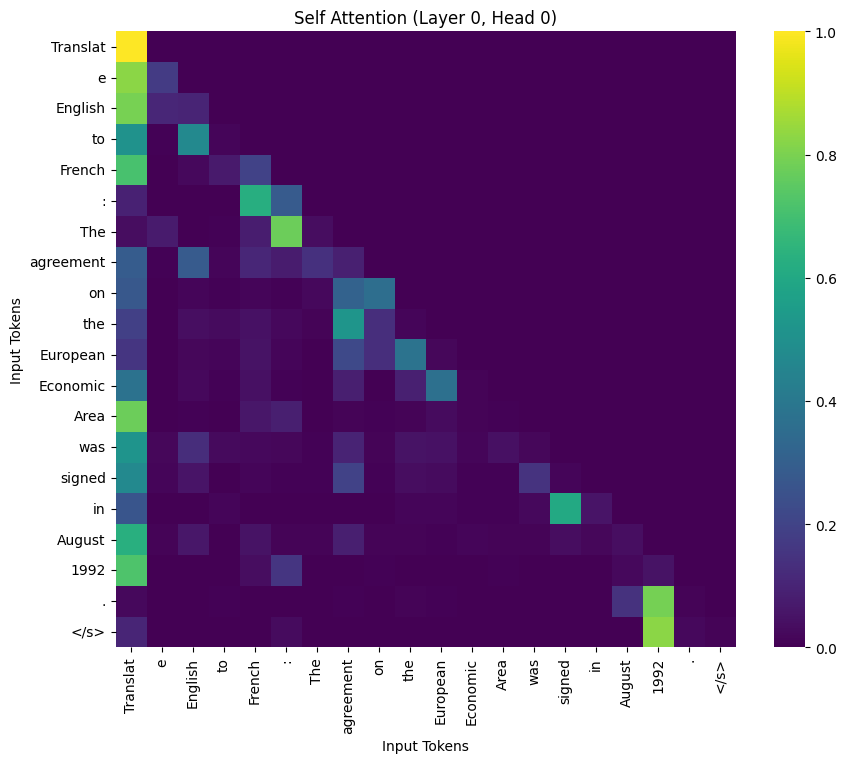

In [161]:
# @title Visualize Attention Weights
text = "Translate English to French: The agreement on the European Economic Area was signed in August 1992." # @param {type:"string"}
layer_to_visualize = -1 # @param {type:"integer"}
head_to_visualize = -1 # @param {type:"integer"}
attention_type = "self" # @param ["cross", "self"]

def visualize_attention(attention_weights, tokens, output_tokens, layer_num, head_num, attention_type):
  attention = attention_weights[layer_num][head_num].detach().cpu().numpy()

  plt.figure(figsize=(10, 8))
  if attention_type == "cross":
    sns.heatmap(attention, xticklabels=tokens, yticklabels=output_tokens, annot=False, cmap='viridis')
  else:
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, annot=False, cmap='viridis')

  plt.title(f"{attention_type.title()} Attention (Layer {layer_num + 1}, Head {head_num + 1})")
  plt.xlabel("Decoder Tokens" if attention_type == "cross" else "Input Tokens")
  plt.ylabel("Encoder Tokens" if attention_type == "cross" else "Input Tokens")
  plt.show()

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model.eval()

self_attentions, cross_attentions, output_sequences = get_attention_weights(text, model, tokenizer)

input_tokens = [tokenizer.decode(token_id) for token_id in tokenizer(text, return_tensors="pt")['input_ids'][0]]
output_tokens = [tokenizer.decode(token_id) for token_id in output_sequences[0]]

if attention_type == "cross":
  visualize_attention(cross_attentions[layer_to_visualize], input_tokens, output_tokens, layer_to_visualize, head_to_visualize, "cross")
else:
  visualize_attention(self_attentions[layer_to_visualize], input_tokens, input_tokens, layer_to_visualize, head_to_visualize, "self")


To gain a deeper understanding of the T5 model's attention mechanisms, you should modify various parameters and observe the resulting changes in attention patterns. This analysis will reveal how the model allocates attention at different stages of processing and how each head within the layers may capture different types of information.

As you perform the analysis, consider the following questions:

<font color="green"><b>

8. How do attention patterns differ between the first and last layers of the model? What does this suggest about the role of initial versus deeper layers in processing the input?
9. What variations do you observe in the attention patterns of different heads within the same layer? Can you hypothesize what different types of information each head might be capturing?
10. How does the complexity or length of the input text influence the attention patterns? Do certain types of sentences result in more or less attention spread across the input tokens?

</b></font>

<font color="red">

8. The initial layer in a transformer model attends to proximate dependencies and elemental linguistic features, prioritizing individual words and their immediate contextual relationships. In contrast, the final layer engages in synthesizing higher-level abstractions and capturing extended dependencies across the input sequence.
9. Within a single layer, the distinct attention heads showcase visible patterns. Notably, in cross attention, there is an observable emphasis on punctuation marks, suggesting a heightened sensitivity to structural cues rather than individual words. Contrarily, in self-attention, a prevalent trend emerges where the initial word of the sentence garners a substantial share of attention, while other words primarily attend to their immediate vicinity. This highlights specialized roles within attention heads, with cross attention prioritizing structural elements and self-attention placing importance on both sentence initiation and local contextual relationships.
10. The complexity of input text can influence attention patterns, with more complex sentences requiring attention to a wider range of linguistic features. Longer sentences may lead to more dispersed attention weights as heads specialize in attending to different sections of the input.

</font>

Document your observations and hypotheses regarding the different attention patterns you observe. Answer the questions provided, supporting your answers with specific examples from your visualizations. This exercise will help you understand the nuanced ways in which the T5 model processes and translates input sequences.





